<a href="https://colab.research.google.com/github/clare-abreu/SCIP/blob/main/SCIP_bootstrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to boostrapping in Python!**

This coding tutorial uses bootstrapping to calculate error bars, and then plots the data and error bars.

It's not always obvious how to calculate an error bar, and boostrapping allows us to re-sample our own data many times to generate error bars that are accurate estimates of variation around the mean. 

*Let's get started!*

First, run the cell below to import the required libraries. This cell also specifies the font sizes for our plot.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import choices

SMALL_SIZE = 16
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

Next, run the cell below to import the dataset from Github.

This is a dataset of two-species competition outcomes among a group of five species of bacteria.

In [ ]:
url ='https://raw.githubusercontent.com/clare-abreu/SCIP/main/experimental_data.csv'
df = pd.read_csv(url)
df

,SpeciesA,SpeciesB,AColonies,BColonies,Afraction,Bfraction,DilutionFactor,Startingfraction,Error
0,1,2,0,43,0.0,1.0,10,0.9,0.021734
1,1,2,0,58,0.0,1.0,100,0.9,0.016391
2,1,2,47,0,1.0,0.0,1000,0.9,0.019996
3,1,2,34,0,1.0,0.0,10000,0.9,0.027017
4,1,2,24,0,1.0,0.0,100000,0.9,0.037010
...,...,...,...,...,...,...,...,...,...
498,4,5,4,0,1.0,0.0,100000,0.1,0.140859
499,4,5,5,0,1.0,0.0,1000000,0.9,0.123718
500,4,5,5,0,1.0,0.0,1000000,0.6,0.123718
501,4,5,2,0,1.0,0.0,1000000,0.4,0.193649


The "Afraction" and "Bfraction" columns contain the final relative abundances of the two species in each competition. (For example, an Afraction of 1.0 means that Species A outcompeted Species B and became 100% of the final population.)

The competitions consisted of five growth-dilution cycles, where the two-species bacterial cultures were diluted every 24 hours into fresh growth medium. The "DilutionFactor" column indicates how much the two-species bacterial culture was diluted each day. A dilution factor of 10 means that 1/10 of the culture was diluted into fresh medium each cyle, while a dilution factor of 1000 means that only 1/1000 of the culture was passed to the next cycle. This experiment tested the hypothesis that higher dilution factors favor faster-growing species, which are better able to re-grow from small densities.

Now let's analyze the data! 

We want to calculate competitive scores of each species at each dilution factor. This means we'll need to average the final fraction of each species at each dilution factor, across all the competitions in which it participated.

Let's make a few empty arrays, which we will use to store the competitive scores and their errors.

In [ ]:
dilution_factors = [10,100,1000,10000,100000,1000000]   # There are six dilution factors
comp_scores = np.zeros([5,6])   # This is an array of competitive scores of each species (five rows) at each dilution factor (six columns).
comp_means = np.zeros([5,6])    # This is a similar array, but instead of the mean score, it will contain the mean bootstrapped score.
comp_SEMs = np.zeros([5,6])     # This array will contain the standard errors of the competitive scores, which is equal to the standard deviations of the bootstrap means.

Now let's bootstrap the data!

The code below first loops over the six dilution factors. For each dilution factor, we then loop over the five species to find all competitive outcomes for each species in each dilution factor. The competitive score is equal to the mean of the competitive outcomes, but notice that this is not quite the same as the bootstrap mean.

The bootstrap mean is calculated by randomly re-sampling, **with replacement**, the dataset of each species in each dilution factor, 1000 times. Because the sampling is done with replacement (after randomly sampling a datapoint, it is replaced before randomly sampling another), each of the 1000 trials will have varying means, since some data points will be sampled more than once. The number of data points per bootstrap trial, or the sample size, is always equal to the actual sample size.

In [ ]:
num_trials=1000   # Number of bootstrap trials
for d in range(len(dilution_factors)):    # Loop over dilution factors
    this_dil = dilution_factors[d]
    df_dil = df[df['DilutionFactor']==this_dil]   # Find all data from this dilution factor
    for k in range(1,6):                  # Loop over species
        this_species_dfA = df_dil[df_dil['SpeciesA']==k]  # Find all data for this species when it is in the "SpeciesA" column
        this_species_dfB = df_dil[df_dil['SpeciesB']==k]  # Find all data for this species when it is in the "SpeciesB" column
        this_species_this_dil = this_species_dfA['Afraction'].tolist() + this_species_dfB['Bfraction'].tolist() # Make a list of all final fractions for this species in this dilution factor
        comp_scores[k-1,d] = np.mean(this_species_this_dil) # Calculate this species' competitive score in this dilution factor (note: this is not the same as the bootstrap mean)
        num_samples = len(this_species_this_dil)          # Determine the sample size so that we can make this the bootstrap sample size
        
        #Bootstrap:
        bootstrap_means = []    # Make an empty list to store bootstrap means for each trial
        for j in range(num_trials):   # Loop over all bootstrap trials
            # The "choices" function below does most of the work of bootstrapping-- it samples randomly from the dataset, with replacement, to form a new dataset
            this_sample = choices(this_species_this_dil, k=num_samples)   
            bootstrap_means.append(np.mean(this_sample))  # Find the mean competitive score for this trial (note: this is probably different for each trial, and from the mean calculated above)
        comp_means[k-1,d] = np.mean(bootstrap_means)    # Find the mean competitive score of all bootstrap trials
        comp_SEMs[k-1,d] = np.std(bootstrap_means)      # Find the standard deviation of all bootstrap trials, which is equivalent to the standard error of the mean

Now we can plot the data!

Below, the mean of the 1000 bootstrap trials is plotted for each species in each dilution factor, and the standard deviation of the bootstrap trials is the standard error of the mean, which we use for the error bars.

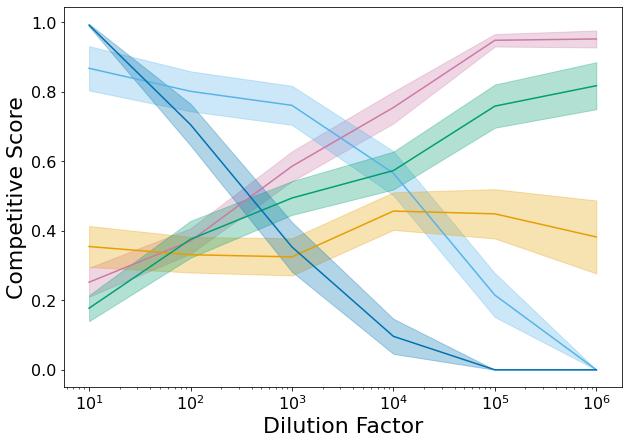

In [ ]:
# Plot the data:

colors = ['#CC79A7','#56B4E9','#E69F00','#009E73','#0072B2']    # These colors correspond to the five species

plt.figure(figsize=(10,7))
for k in range(5):    # Loop over species
    plt.plot(dilution_factors,comp_means[k,:], color=colors[k])   # Plot the bootstrap means of this species over all dilution factors
    plt.fill_between(dilution_factors,comp_means[k,:]-comp_SEMs[k,:], comp_means[k,:]+comp_SEMs[k,:],alpha=0.3, edgecolor=colors[k], facecolor=colors[k]) # Plot the error bars using the standard deviations of the bootstrap trials
plt.ylabel('Competitive Score')
plt.xlabel('Dilution Factor')
plt.xscale("log")
plt.show()  
    

Questions:

  1. Why are some of the error bars equal to zero (for example, the dark blue species at the lowest dilution factor)?

  2. Compare the actual competitive scores (comp_scores) to the mean bootstrap competitive scores (comp_means). Are they similar?

  3. This experiment showed that increasing dilution favors faster-growing species. Which do you think are the fastest-growing species?

Coding Problem:

Change the code above to re-do the bootstrap with a sample size set to 3 (instead of the actual sample size). How does this change the width of the error bars? And how does it change the similarity between the actual competitive scores and the mean bootstrap competitive scores?